# __Step 3.3: Cluster analysis__

The goals for step 3.3 are to:
- Identify "enriched" vocab words in each cluster
- Determine relations between clusters
- Assess the number of citations in each cluster chronologically

7/14/22: Initial analysis using KMeans results are not encouraging: there is little structure between clusters which hinders interpretation. Go on to topic modeling.

## ___Set up___

### Module import

In [2]:
import os, pickle, math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from pathlib import Path
from tqdm import tqdm
from scipy.stats import ks_2samp
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering

### Key variables

In [3]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "3_key_term_temporal/3_3_cluster_analysis"
work_dir.mkdir(parents=True, exist_ok=True)

os.chdir(work_dir)

# plant science corpus
dir25       = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = dir25 / "corpus_plant_421658.tsv.gz"

# qualified feature names
dir31          = proj_dir / "3_key_term_temporal/3_1_pubmed_vocab"
X_vec_file     = dir31 / "tfidf_sparse_matrix_4542"
feat_name_file = dir31 / "tfidf_feat_name_and_sum_4542"

# fitted clustering objs
dir32            = proj_dir / "3_key_term_temporal/3_2_tf_idf_clustering"
clus_kmeans_file = dir32 / 'clus_kmeans'
cluster_num      = 500


## ___Get clustering results___

### KMeans

In [4]:
# Load kmean fit in case the session died.
with open(clus_kmeans_file, "rb") as f:
  clus_kmeans = pickle.load(f)

In [5]:
labels_kmeans = clus_kmeans.labels_
type(labels_kmeans), labels_kmeans.shape, labels_kmeans[:20]

(numpy.ndarray,
 (421658,),
 array([345, 310, 329,  66,   8, 299, 443, 116, 297, 297, 325, 121, 499,
        310, 162, 125, 116,  54,  67, 310], dtype=int32))

In [6]:
# {cluster_number: [indices of docs in the cluster]}
dict_kmeans = {}
for i in range(len(labels_kmeans)):
  label = labels_kmeans[i]
  if label not in dict_kmeans:
    dict_kmeans[label] = [i]
  else:
    dict_kmeans[label].append(i)


In [7]:
dict_kmeans_size = {}
for i in dict_kmeans:
  dict_kmeans_size[i] = len(dict_kmeans[i])
dict_kmeans_size_df = pd.DataFrame(list(dict_kmeans_size.items()), 
                                   columns=['cluster', 'size'])

In [8]:
dict_kmeans_size_df.describe()

,cluster,size
count,500.000000,500.000000
mean,249.500000,843.316000
std,144.481833,633.347277
min,0.000000,74.000000
25%,124.750000,424.750000
50%,249.500000,697.000000
75%,374.250000,1118.750000
max,499.000000,7915.000000


## ___"Enriched" vocab words___

- Am using Tf-idf values, so not the typically enrichment we are talking about here. More like, for a term, in a cluster X, the Tf-idf distribution is significantly differnt from Tf-idf values of the rest.
- So need to get a Tf-idf matrix for each cluster and anotehr for the rest.
- Do KS test, but instead of using all values, use max 10,000 values, if subsampling is needed, it is done 10 times. And the median p-value for KS test is used as the test stat.

### Read Tf-idf matrix and feat names

In [9]:
# Load sparse matrix from a pickle
with open(X_vec_file, 'rb') as f:
  X_vec = pickle.load(f)

# Load feature names and tf-idf sum
feat_sum = pd.read_csv(feat_name_file, sep='\t', index_col=0)

X_vec.shape, feat_sum.shape

((421658, 4542), (4542, 2))

### Functions

#### Get Tf-idx submatrix 

In [26]:
def get_submatrices(X_vec, labels, target_label):

  target_list  = []
  nontar_list  = []

  # Populate target and non-target lists with indices
  for i in range(len(labels_kmeans)):
    label = labels[i]
    if label == target_label:
      target_list.append(i)
    else:
      nontar_list.append(i)

  # convert to numpy array
  target_array = np.array(target_list)
  nontar_array = np.array(nontar_list)

  # Get the sparse matrix columns based on indices
  X_vec_target = X_vec[target_array, :]
  X_vec_nontar = X_vec[nontar_array, :]
  #print(f"  target:{X_vec_target.shape}, non-target:{X_vec_nontar.shape}")

  return X_vec_target, X_vec_nontar

#### For conducting ks_test

In [24]:
def ks_test(label):
 
  X_vec_target, X_vec_nontar = get_submatrices(X_vec, labels_kmeans, label)
  num_feat = X_vec_target.shape[1]

  dict_results = {} # {feat_index:[effect size, stat, pval]}
  for feat_index in range(num_feat):
    target_array = X_vec_target[:, feat_index].toarray().flatten()
    nontar_array = X_vec_nontar[:, feat_index].toarray().flatten()

    target_median = np.median(target_array)
    nontar_median = np.median(nontar_array)
    effect_size   = target_median-nontar_median

    if target_median > nontar_median:
      result = ks_2samp(target_array, nontar_array)
      dict_results[feat_index] = [effect_size, result.statistic, result.pvalue]

  return dict_results

### Get test stat for kmean clsuters through parallization

- https://superfastpython.com/multiprocessing-pool-apply/
- https://clay-atlas.com/us/blog/2021/08/02/python-en-use-multi-processing-pool-progress-bar/
- https://bentyeh.github.io/blog/20190722_Python-multiprocessing-progress.html
- https://inside-machinelearning.com/en/parallelization-in-python-getting-the-most-out-of-your-cpu/
- https://stackoverflow.com/questions/5666576/show-the-progress-of-a-python-multiprocessing-pool-imap-unordered-call

Was using `pool.apply` and it did not parallize. Then switch to `pool.imap`. I probably setup apply wrong anyway.

```Python
with mp.Pool(mp.cpu_count()) as pool:
  for label in range(cluster_num):
    dict_results = pool.apply(ks_test, args=(label,))
    dict_results_list.append(dict_results)
```

If I run as one process, each cluster is ~2min, so 500 cluster is 1000 min which is ~16-17 hours. 
- With the code below that presumably used 16 parallel processes, this should be done in 1 hours. But it went on for six hours. 
- Do this in HPC instead and break down the process into 20 jobs each with 25 clusters.

In [ ]:
# Go through different clusters

#dict_results_list = []
#with mp.Pool(mp.cpu_count()) as pool:
#  for dict_results in tqdm(pool.imap(ks_test, range(cluster_num)), 
#                           total=cluster_num):
#    dict_results_list.append(dict_results)

In [ ]:
# Dump the results as a pickle
#with open(work_dir / "dict_results_list_kmeans", 'wb') as f:
#  pickle.dump(dict_results_list, f)

### Consolidate test stat objects

The 500 clusters were processed in 20 jobs. Each lead to a dict_result_list that needs to be combined.

In [16]:
dict_results_list_all = []
for label in range(0, 500, 25):
  dict_results_list_file = work_dir / \
                              f'dict_results_list_kmeans_C{label}-{label+25}'
  with open(dict_results_list_file, "rb") as f:
    # script_3_3_ks_test.py make the end range to be inclusive. So the last 
    # entry in each batch is repeated as the 1st in the next batch. 
    dict_results_list = pickle.load(f)[:-1]
    print(f"begin:{label}, len:{len(dict_results_list)}")
    dict_results_list_all.extend(dict_results_list)

begin:0, len:25
begin:25, len:25
begin:50, len:25
begin:75, len:25
begin:100, len:25
begin:125, len:25
begin:150, len:25
begin:175, len:25
begin:200, len:25
begin:225, len:25
begin:250, len:25
begin:275, len:25
begin:300, len:25
begin:325, len:25
begin:350, len:25
begin:375, len:25
begin:400, len:25
begin:425, len:25
begin:450, len:25
begin:475, len:25


In [17]:
len(dict_results_list_all), feat_sum.shape, feat_sum.shape[0]

(500, (4542, 2), 4542)

In [18]:
# Go through each cluster and construct a p-value array, then add to the
# feat_sum dataframe
# Minimum non=zero p-val is 1.4e-322. So set pval=0 to 1.e-322

feat_num = feat_sum.shape[0]
pvals_list = []
colnm_list = []
min_pval   = 1
for label in range(cluster_num):
  dict_results = dict_results_list_all[label]
  pvals = []
  for feat_idx in range(feat_num):
    if feat_idx in dict_results:

      # -log transofmr the pval
      pval = dict_results[feat_idx][-1]
      if pval != 0:
        if pval < min_pval:
          min_pval = pval
        pval_transform = -math.log(pval, 10)
      
      # pval=0, change to pval=1e-322
      else:
        pval_transform = 322
      pvals.append(pval_transform)
    
    # Do not have test stat because mean tf-idf is not higher than mean, 
    # set to 0
    else:
      pvals.append(0)

  # Convert to series for 
  pvals_list.append(pd.Series(pvals))
  colnm_list.append(f'C{label}')

print("min_pval:", min_pval)
feat_pvals = pd.concat(pvals_list, axis=1)
feat_pvals.columns = colnm_list
feat_pvals.shape

min_pval: 1.4e-322


(4542, 500)

In [20]:
feat_sum2 = feat_sum.reset_index()
feat_sum2.head(2)

,index,Features,Tf-idf sum
0,9,abscisic acid,967.217504
1,10,abscission,278.771575


In [21]:
feat_sum_pvals = pd.concat([feat_sum2, feat_pvals], axis=1)
feat_sum_pvals.shape, feat_sum_pvals.head(2)

((4542, 503),
    index       Features  Tf-idf sum   C0   C1   C2   C3  C4  C5   C6  ...  \
 0      9  abscisic acid  967.217504  0.0  0.0  0.0  0.0   0   0  0.0  ...   
 1     10     abscission  278.771575  0.0  0.0  0.0  0.0   0   0  0.0  ...   
 
    C490  C491  C492  C493  C494  C495  C496  C497  C498  C499  
 0   0.0   0.0     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
 1   0.0   0.0     0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
 
 [2 rows x 503 columns])

In [22]:
# The above is not as nice for getting an heatmap. Just set the feat_pvals
# dataframe to have feature names as indices.
#feat_pvals.insert(loc=0, column='feat', value=feat_sum['Features'].values)
feat_pvals.set_index(feat_sum['Features'].values, inplace=True)
feat_pvals.head(2)

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C490,C491,C492,C493,C494,C495,C496,C497,C498,C499
abscisic acid,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abscission,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
type(feat_pvals.sum(axis=1).values)

numpy.ndarray

In [24]:
# filtering out features that is not significant in any clsuter
feat_pvals["row_sum"] = feat_pvals.sum(axis=1).values
feat_pvals_subset = feat_pvals[feat_pvals['row_sum'] > 0]
feat_pvals_subset.shape

(849, 501)

In [25]:
# rid of row sum and save
del feat_pvals_subset['row_sum']
feat_pvals_subset.to_csv(work_dir/"table_feat_pvals_subset_kmean.tsv", sep='\t')
feat_pvals_subset.shape

(849, 500)

### Heatmap showing relationships between signifcaint features and clusters

- https://cmdlinetips.com/2020/01/heatmaps-with-seaborns-clustermap/
  - But only work if the data is in tidy long form
- https://blog.tdwi.eu/hierarchical-clustering-in-python/
  - Did not explain how to "bring it into a matrix format".
- https://datavizpyr.com/hierarchically-clustered-heatmap-with-seaborn-in-python/

7/14/22 Get `RecursionError: maximum recursion depth exceeded while getting the str of an object`.
- See [this](https://github.com/scipy/scipy/issues/7271), solution is to use method other than single or complete.

/home/shinhan/miniconda3/envs/tf/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


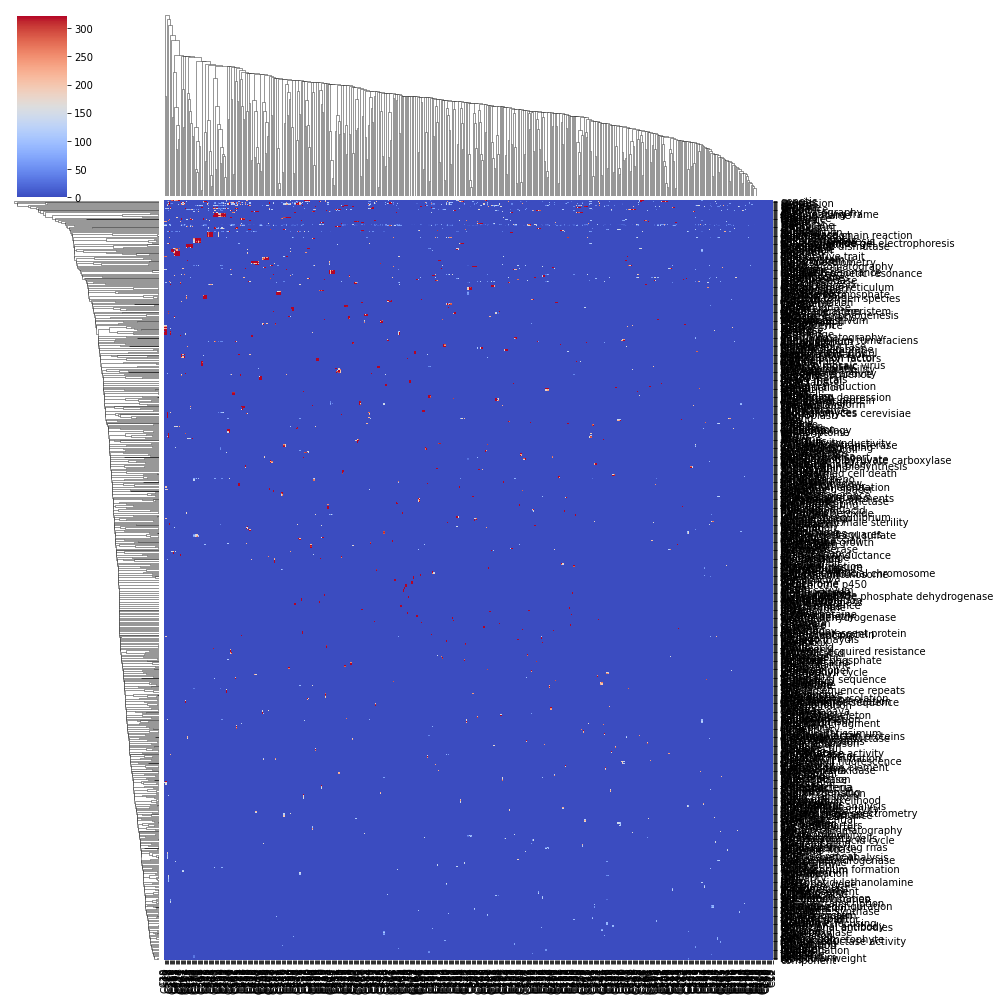

In [132]:
g_feat_pvals_subset = sns.clustermap(feat_pvals_subset, method='average', 
                                     cmap='coolwarm', figsize=(14, 14), 
                                     yticklabels=True, xticklabels=True)

In [134]:
g_feat_pvals_subset.savefig(work_dir / 'figure3_3_feat_pval_subset_kmean.pdf')

## ___Relations between clusters___

### Cluster centroid correlation

In [10]:
# Get centroid
clus_kmeans_centers = clus_kmeans.cluster_centers_
type(clus_kmeans_centers), clus_kmeans_centers.shape

(numpy.ndarray, (500, 100))

In [11]:
# Get correlation matrix
clus_kmeans_centers_cor = np.corrcoef(clus_kmeans_centers)
clus_kmeans_centers_cor.shape

(500, 500)

/home/shinhan/miniconda3/envs/tf/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


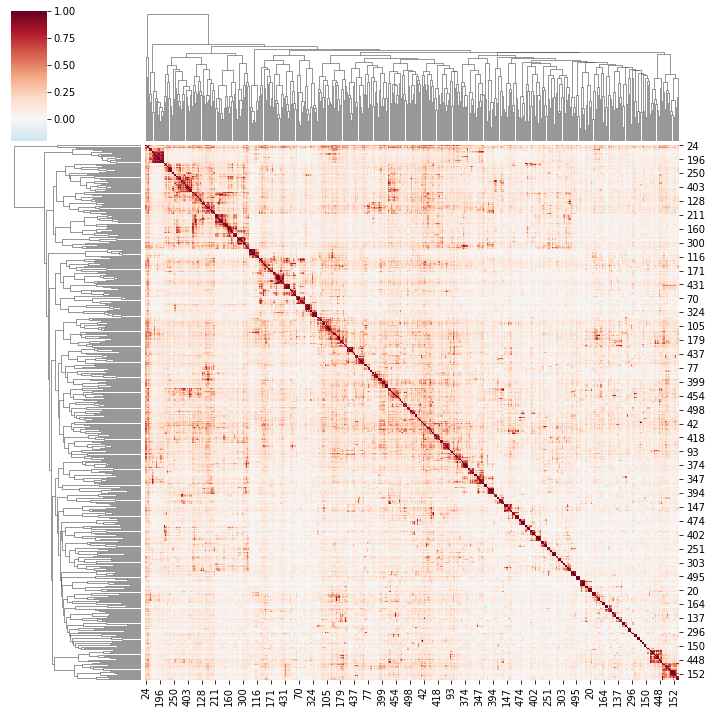

In [12]:
g_clus_kmeans_centers_cor = sns.clustermap(clus_kmeans_centers_cor, center=0, 
                                           cmap="RdBu_r")

In [13]:
g_clus_kmeans_centers_cor.savefig(work_dir / \
                                      'figure3_3_clus_kmeans_centers_cor.pdf')

### Get K-mean super-clusters

- https://www.nxn.se/valent/extract-cluster-elements-by-color-in-python
- https://skytowner.com/explore/comprehensive_guide_on_hierarchical_clustering

7/14/22: Almost all kmean clusters are in the 0th Agglomerative "super" cluster. Not working. Need to try other clustering methods.

In [14]:
aggclust = AgglomerativeClustering(n_clusters=20, linkage='average')
aggclust.fit_predict(clus_kmeans_centers)
aggclust_clus_keans_centers_labels = aggclust.labels_
len(aggclust_clus_keans_centers_labels)

500

In [26]:
clus_feat = feat_pvals_subset.T
clus_feat['aggclust'] = aggclust_clus_keans_centers_labels

In [27]:
clus_feat['aggclust'].value_counts()

0     464
4       6
8       3
1       3
2       3
6       3
18      2
3       2
14      2
9       2
13      1
17      1
12      1
15      1
11      1
16      1
5       1
7       1
19      1
10      1
Name: aggclust, dtype: int64

In [158]:
clus_feat.head()

,abscisic acid,acclimation,acetic acid,acid,amino acid,ammonia,firmicutes,fitness,fixation,flavonoid,...,beech,triticum aestivum,floral meristem,plant cell,female gametophyte,shoot apical meristem,calibration,partial least squares,pls,aggclust
C0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
C1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
C3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
C4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [160]:
clus_feat_aggclust_aggregate = clus_feat.groupby('aggclust').agg('mean')
clus_feat_aggclust_aggregate.head()

,abscisic acid,acclimation,acetic acid,acid,amino acid,ammonia,firmicutes,fitness,fixation,flavonoid,...,vicia,beech,triticum aestivum,floral meristem,plant cell,female gametophyte,shoot apical meristem,calibration,partial least squares,pls
aggclust,,,,,,,,,,,,,,,,,,,,,
0,0.195129,1.084086,0.670833,10.493285,3.502316,0.670833,0.308351,0.0,1.061455,0.597046,...,1.341667,1.14205,1.25614,0.208483,1.304981,0.169397,1.341667,0.0,0.171167,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


## ___FOR LATER___

### Read corpus file with date and journal info

In [ ]:
corpus_df = pd.read_csv(corpus_file, sep='\t', compression='gzip')
corpus_df.shape